In [11]:
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import MSTL
from datetime import datetime


# importar librerias 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
from datetime import datetime

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time





In [12]:
# abrir datos contugas

new1 = pd.read_excel('EICH106.xlsx')
new1.columns = ['VOLUMEN CORREGIDO', 'STD_VOLUME', 'ORIG_TEMPERATURE', 'TEMPERATURA','PRESION', 'ORIG_PRESSURE', 'VOLUMENSINCORREGIR', 'RAW_VOLUME', 'FECHAINICIAL']

#función que pone las fechas en el mismo formato
def cambiofecha(row):
    
    for i in range(len(row)):
        if isinstance(row.at[i, 'FECHAINICIAL'], str):
            row.at[i, 'FECHAINICIAL'] = pd.to_datetime(row.at[i, 'FECHAINICIAL']).strftime('%Y-%m-%d %H:%M:%S')  
        elif isinstance(row.at[i, 'FECHAINICIAL'], datetime):
            row.at[i, 'FECHAINICIAL'] = datetime.strptime(str(row.at[i, 'FECHAINICIAL']),'%Y-%d-%m %H:%M:%S')
            row.at[i, 'FECHAINICIAL'] = row.at[i, 'FECHAINICIAL'].strftime('%Y-%m-%d %H:%M:%S')

    return row

new1=cambiofecha(new1)

new1 = new1.set_index('FECHAINICIAL')
new1.index = pd.to_datetime(new1.index, format='%Y-%m-%d %H:%M:%S')


# Función que añade al dataframe la hora, dia de la semana, mes y dia del año.
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    #df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    #df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    #df['dayofmonth'] = df.index.day
    #df['weekofyear'] = df.index.isocalendar().week
    return df


new1 = create_features(new1)

datos1=new1[["PRESION", "TEMPERATURA", "VOLUMENSINCORREGIR", "hour", "dayofweek", "month", "dayofyear"]]


#función que elimina las anomalias 

def eliminar_anomalias(df1,Vol,VolMin,VolMax,Temp,TempMin,TempMax,Presion,PresMin,PresMax):

    df=df1.copy()

    if Vol == True:
        df["VOLUMENSINCORREGIR"]= np.where((df["VOLUMENSINCORREGIR"]<VolMin)|(df["VOLUMENSINCORREGIR"]>VolMax),df['VOLUMENSINCORREGIR'].shift(168),df['VOLUMENSINCORREGIR'])

    if Presion == True:
        df["PRESION"]= np.where((df["PRESION"]<PresMin)|(df["PRESION"]>PresMax),df['PRESION'].shift(168),df['PRESION'])

    if Temp == True:
        df["TEMPERATURA"]= np.where((df["TEMPERATURA"]<TempMin)|(df["TEMPERATURA"]>TempMax),df['TEMPERATURA'].shift(168),df['TEMPERATURA'])


    return df



datos1=eliminar_anomalias(datos1,   True,0,250,True,17,35,True,14,19) ## Falta Presion

In [13]:
datos1

,PRESION,TEMPERATURA,VOLUMENSINCORREGIR,hour,dayofweek,month,dayofyear
FECHAINICIAL,,,,,,,
2018-10-24 10:00:00,17.812536,23.294756,0.000,10,2,10,297
2018-10-24 11:00:00,17.785923,24.879368,48.687,11,2,10,297
2018-10-24 12:00:00,17.849327,25.593176,25.125,12,2,10,297
2018-10-24 13:00:00,17.783957,24.487469,3.563,13,2,10,297
2018-10-24 14:00:00,17.840059,24.522886,3.312,14,2,10,297
...,...,...,...,...,...,...,...
2024-01-25 06:00:00,17.368910,27.570827,0.000,6,3,1,25
2024-01-25 07:00:00,17.370106,27.505213,0.000,7,3,1,25
2024-01-25 08:00:00,17.403006,27.323944,0.000,8,3,1,25


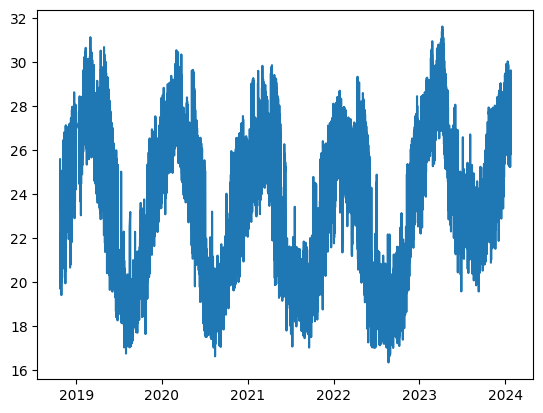

In [14]:
plt.plot(datos1['TEMPERATURA'])

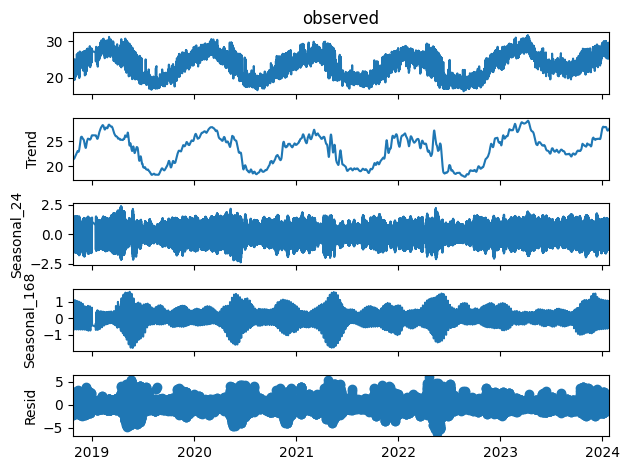

In [15]:
mstl = MSTL(datos1['TEMPERATURA'], periods=[24, 24 * 7], iterate=5, stl_kwargs={"seasonal_deg": 0,
                                                                          "inner_iter": 2,
                                                                          "outer_iter": 0})
res = mstl.fit() # Use .fit() to perform and return the decomposition
ax = res.plot()
plt.tight_layout()







In [16]:
res.trend

tendencia = res.trend
seasonal = res.seasonal
residual = res.resid


In [17]:
Datos = tendencia + seasonal['seasonal_168'] + seasonal['seasonal_24'] + residual

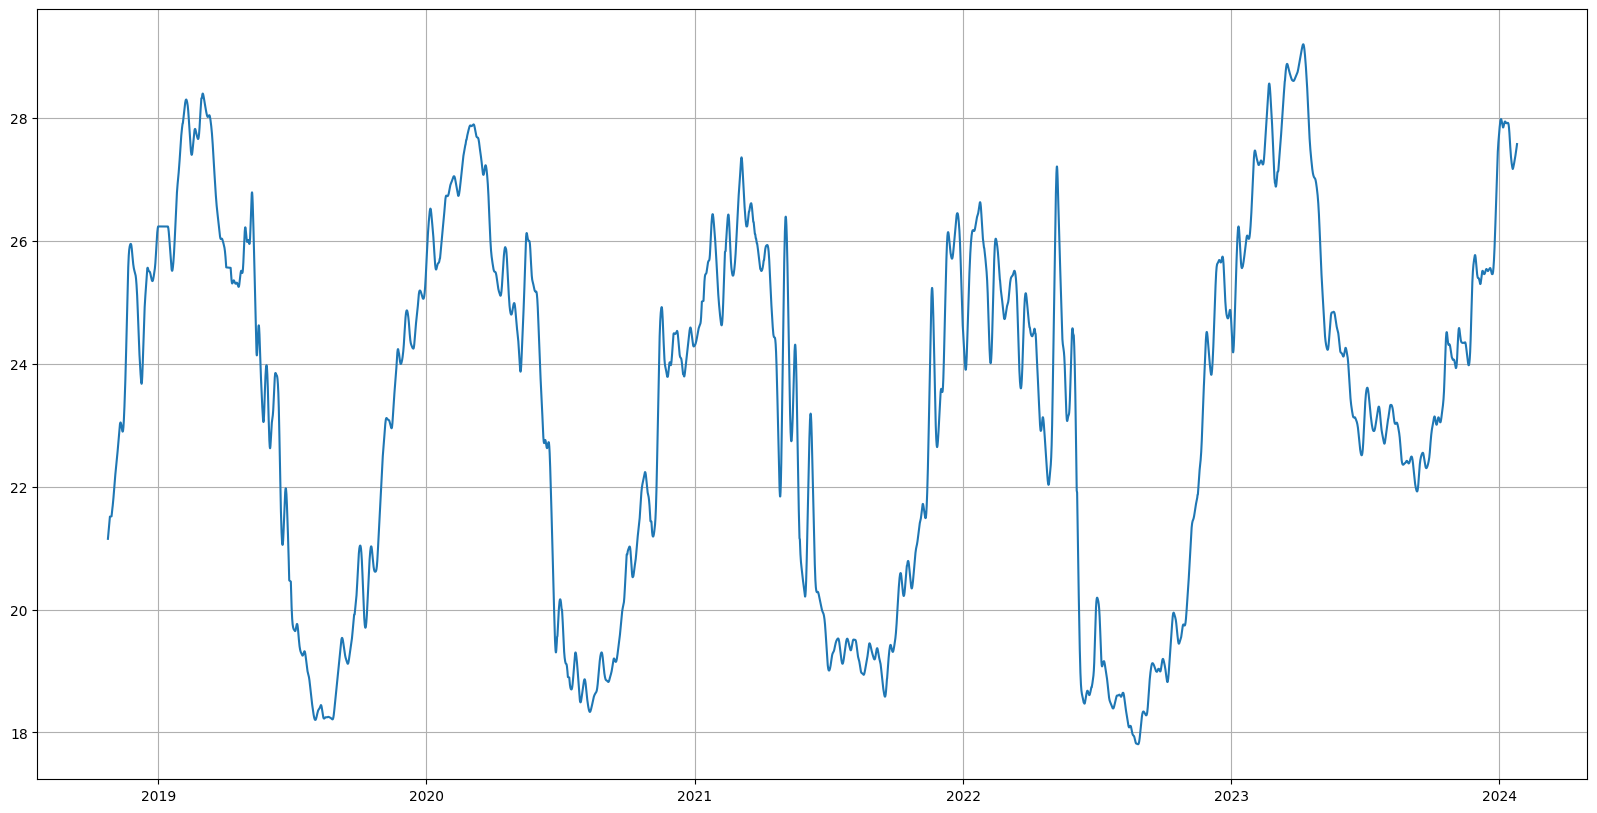

In [18]:
plt.figure(figsize=(20,10))
plt.plot(tendencia)
plt.grid()


In [19]:
tendenciaFourier = np.fft.fft(tendencia)

# Generar el ruido Laplaciano y aplicarlo a los coeficientes de Fourier
b = 50
deltaf = 1
epsilon = deltaf/ b

# loc = media, scale = b
laplace = np.random.laplace(loc=0, scale=1/epsilon,size = tendenciaFourier.shape )

#laplace_noise = np.random.laplace(loc=0, scale=b, size=tendenciaFourier.shape)
perturbed_trend_dft = tendenciaFourier + laplace


In [20]:
laplace

array([-13.63035748, 156.82265345, -15.29989641, ...,  90.73333347,
        34.85878761,   2.56899607])

In [21]:
perturbed_trend = np.fft.ifft(perturbed_trend_dft).real


In [22]:
DatosRuido = perturbed_trend + seasonal['seasonal_168'] + seasonal['seasonal_24'] + residual

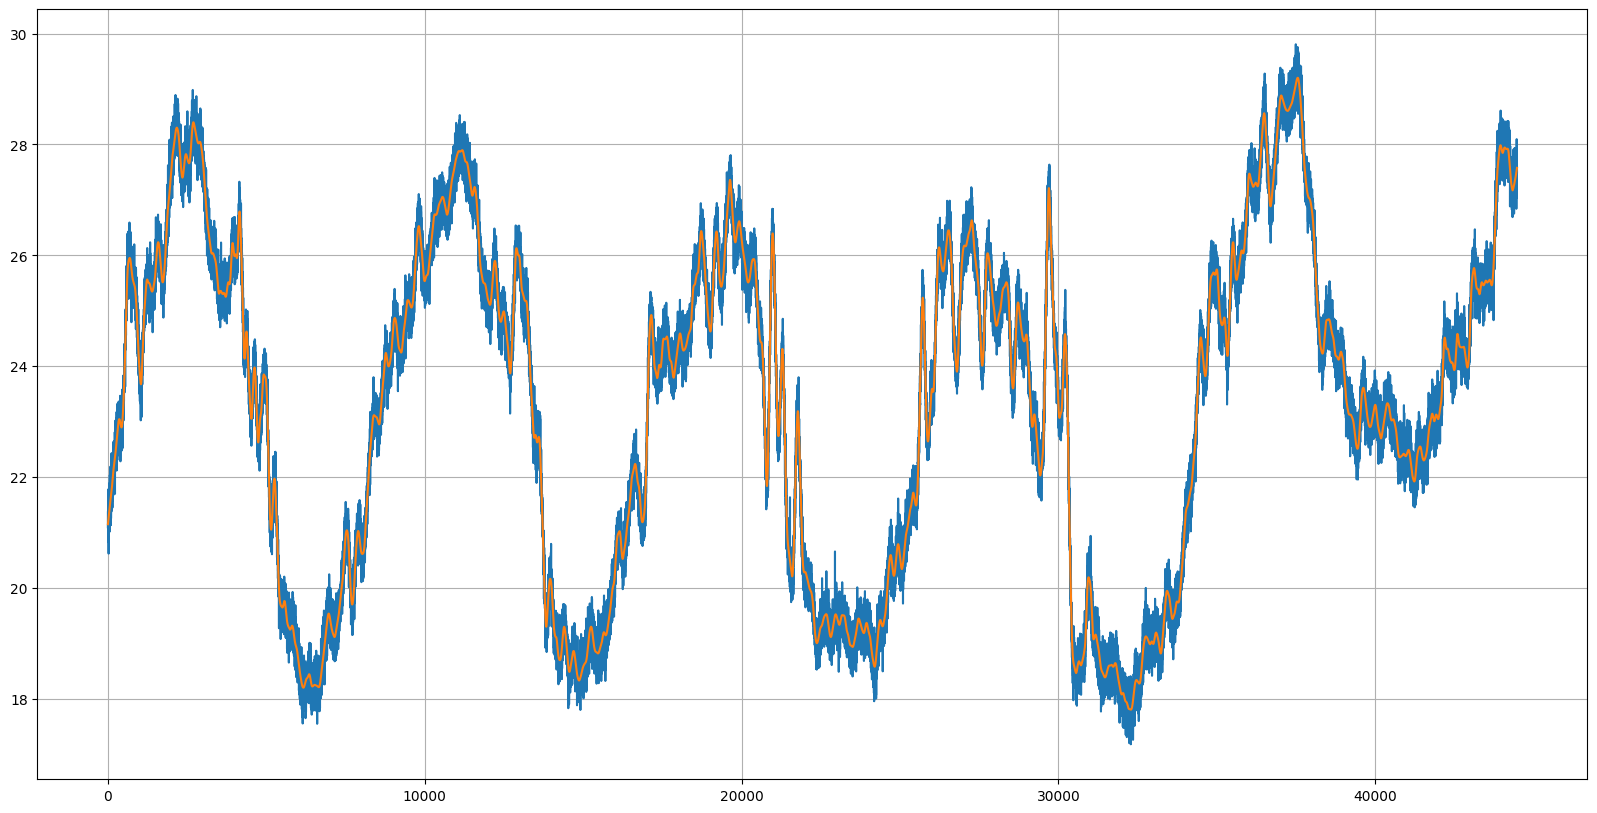

In [23]:
plt.figure(figsize=(20,10))
plt.plot(perturbed_trend[:])
plt.plot(tendencia.values[:])
plt.grid()


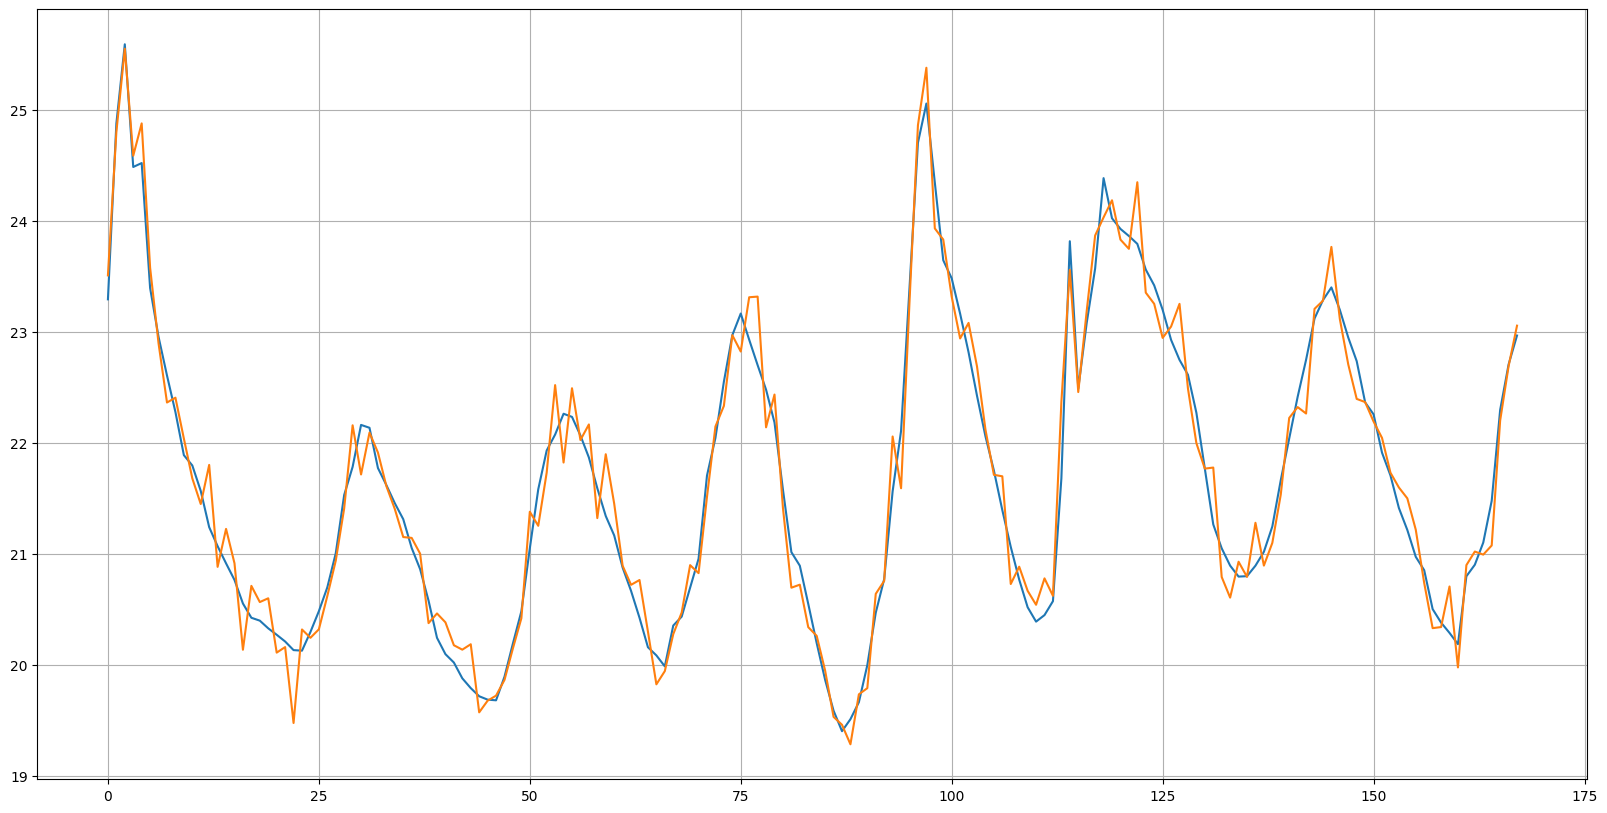

In [30]:
plt.figure(figsize=(20,10))
plt.plot(datos1['TEMPERATURA'][:168].values)
plt.plot(DatosRuido.values[:168])
plt.grid()